# Text Submission Criteria

Please submit your analysis based on the following criteria:

1. **Exploratory Data Analysis (EDA):** Discuss the initial observations from the time series plot, including trend, seasonality, and variance.
2. **Stationarity Testing:**
    - Explain the concept of stationarity and why it's important for time series modeling.
    - Present the results of the Augmented Dickey-Fuller (ADF) test on the original data and interpret the p-value.
    - Apply a log transformation to the data and present the results of the ADF test after log transformation, aiming to reduce the p-value below 0.05. Discuss your findings.
    - Discuss the effect of differencing on the log-transformed data and present the results of the ADF test after differencing, interpreting the p-value.
3. **ARIMA Model Performance:** Based on the stationarity test results after log transformation (before differencing), discuss whether you would expect a non-seasonal ARIMA model to perform well on the log-transformed data. Build and evaluate a non-seasonal ARIMA model on the log-transformed data (without differencing) and compare its performance to the SARIMA model built later in the notebook.

In [1]:
pip install statsmodels

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [29]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [49]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)
k=df.copy()

### 1. **Exploratory Data Analysis (EDA):

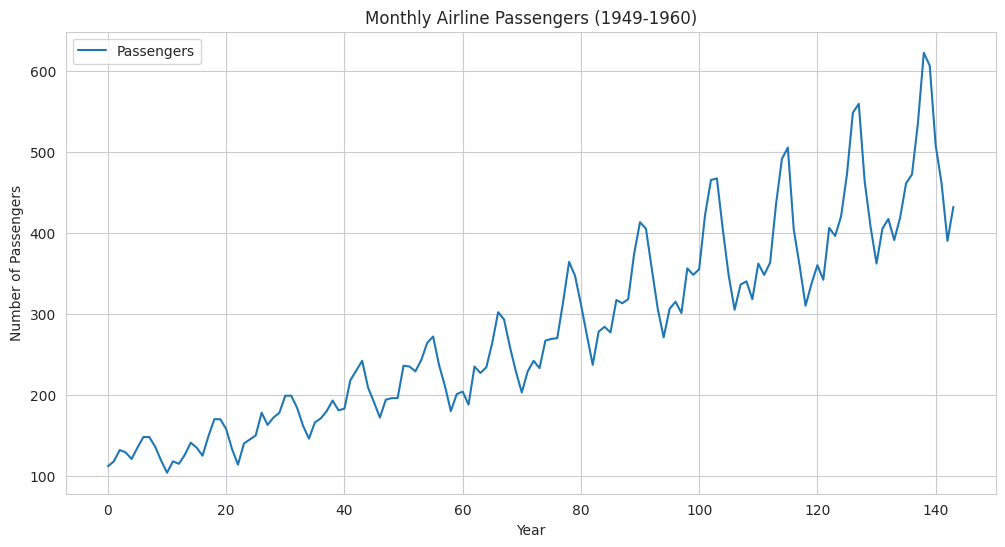

In [50]:
# Plot the time series
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

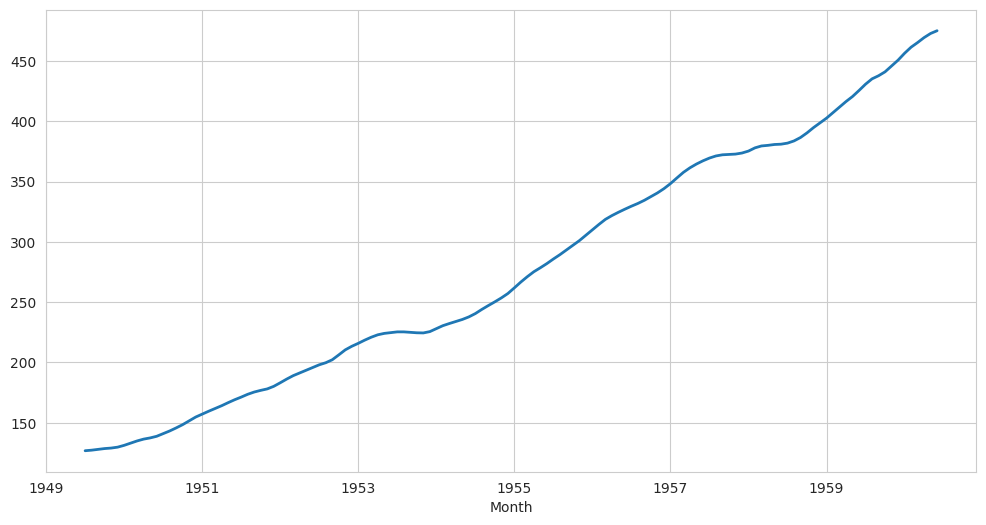

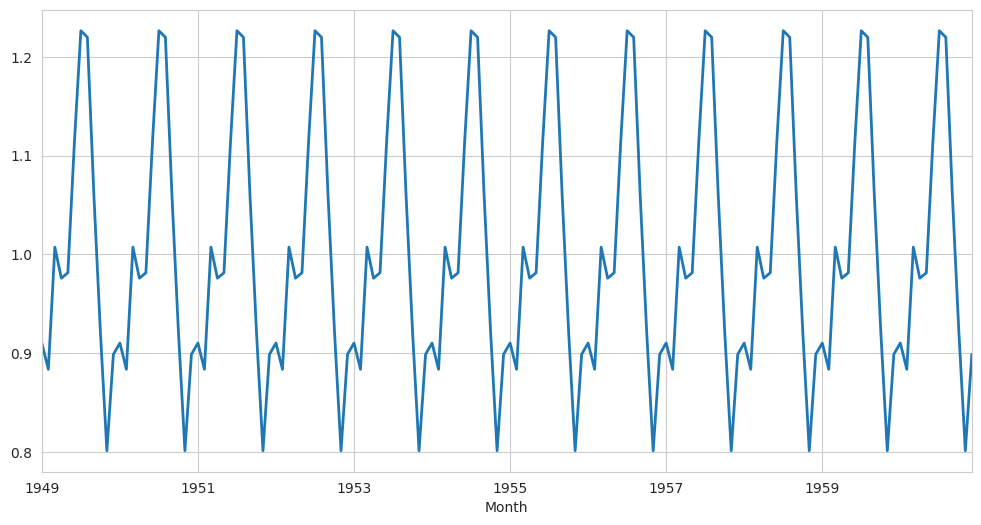

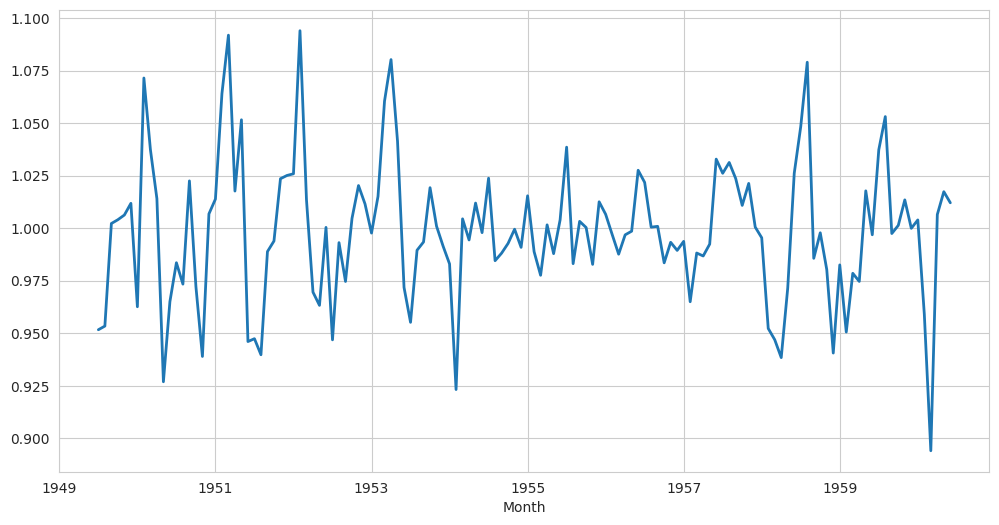

In [51]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative',period =12)

fig = decomposition.trend.plot( linewidth=2)
plt.show()
fig1 = decomposition.seasonal.plot( linewidth=2)
plt.show()
fig2 = decomposition.resid.plot( linewidth=2)
plt.show()


### Insights:
- The number of passengers is increasing over time in trend
- There is a clear, repeating annual pattern as seasonal(peaks and troughs within each year).
- The seasonal fluctuations appear to be getting larger over time.

In [52]:
k=df

Daily DataFrame:


/tmp/ipython-input-371756800.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily['Passengers'] = df_daily['Passengers'].fillna(method='ffill')


,Passengers
1949-01-01,112.0
1949-01-02,112.0
1949-01-03,112.0
1949-01-04,112.0
1949-01-05,112.0


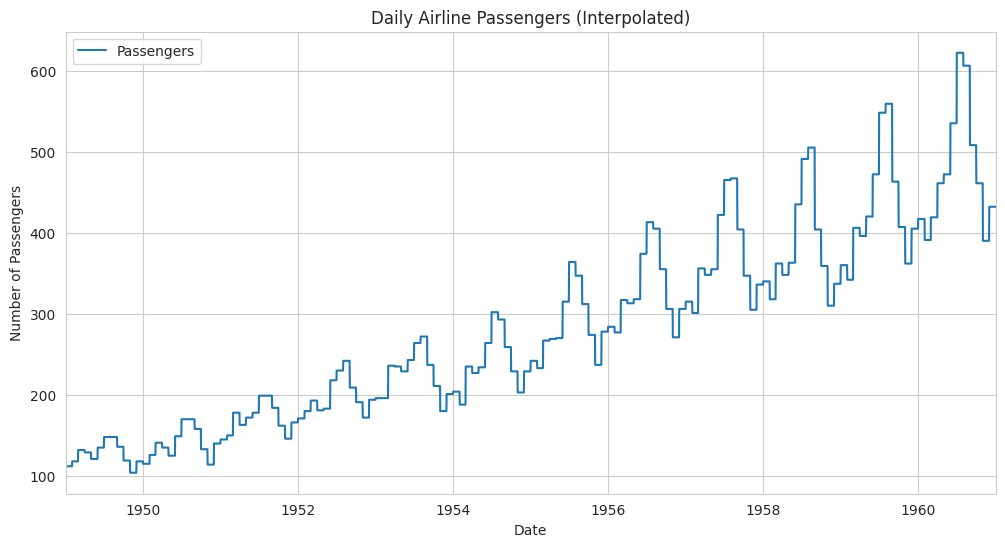

In [53]:
# Create a daily date range
daily_dates = pd.date_range(start=df.index.min(), end=df.index.max() + pd.offsets.MonthEnd(0), freq='D')

# Create a new daily DataFrame
df_daily = pd.DataFrame(index=daily_dates)

# Merge the daily DataFrame with the original monthly DataFrame
df_daily = df_daily.merge(df, left_index=True, right_index=True, how='left')

# Forward fill the monthly passenger values to the daily entries
df_daily['Passengers'] = df_daily['Passengers'].fillna(method='ffill')

# Display the first few rows of the daily DataFrame
print("Daily DataFrame:")
display(df_daily.head())

# Plot the daily time series (optional, for visualization)
df_daily.plot()
plt.title('Daily Airline Passengers (Interpolated)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()
df=df_daily

###  Stationarity Testing
Before we can build a model like ARIMA, the time series needs to be **stationary**.
#### **Theoretical Concept: Stationarity**
A time series is said to be stationary if its statistical properties—specifically the **mean**, **variance**, and **autocorrelation**—are all constant over time.

- **Why is it important?** Stationary series are easier to model and forecast. If a series is stationary, its past behavior is a good predictor of its future behavior. Our passenger data is clearly **non-stationary** because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

**How to test for it?**
1.  **Visual Inspection:** Look at the plot. Is there a clear trend or seasonality?
2.  **Statistical Tests:** The **Augmented Dickey-Fuller (ADF) Test** is a common statistical test.
    - **Null Hypothesis ($H_0$):** The series is non-stationary.
    - **Alternative Hypothesis ($H_1$):** The series is stationary.

We want to **reject the null hypothesis**. To do this, we need the **p-value** from the test to be less than a significance level (e.g., 0.05).

#### Think of the ADF test as asking the question: "Does this time series have a trend or other patterns that make it non-stationary?"

Here's what each part means:

* Test Statistic: This is a number calculated from your data. It's the main result of the test.
* p-value: This is the most important number for a beginner. It tells you how likely it is that you would get your results if the time series were actually stationary (which is the opposite of what we usually want).
* If the p-value is small (usually less than 0.05): This means it's very unlikely to get these results if the series were stationary. So, you can confidently say, "Okay, this series is not stationary."
* If the p-value is large (like yours, 0.99): This means it's quite likely to get these results even if the series were stationary. So, you cannot confidently say it's not stationary. In other words, you fail to reject the null hypothesis, which is that the series is non-stationary.
###Lags Used: This is the number of past data points the test looked at to help make its decision.
* Number of Observations Used: This is how many data points from your time series were actually used in the test calculation.
* Critical Value (1%), (5%), (10%): These are threshold values. If your "Test Statistic" is smaller than one of these critical values (more negative), you would reject the null hypothesis at that confidence level. For example, if your Test Statistic was less than -3.48 (the 1% critical value), you'd be very confident (99%) that the series is stationary.
Why do we use it?

* We use the ADF test (and look at the p-value) because many powerful time series forecasting models, like ARIMA, assume that the data they are working with is stationary. If your data is not stationary, these models might not work well or give you inaccurate forecasts. The ADF test gives us a statistical way to check this assumption before we build our models.

* In your case, the high p-value (0.99) tells us that your 'Passengers' data is non-stationary, just as we suspected from looking at the plot earlier. This confirms that you need to perform transformations (like differencing) to make it stationary before building an ARIMA model.

In [54]:

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.337798
p-value                           0.160067
#Lags Used                       31.000000
Number of Observations Used    4351.000000
Critical Value (1%)              -3.431854
Critical Value (5%)              -2.862205
Critical Value (10%)             -2.567124
dtype: float64


### The p-value is 0.16

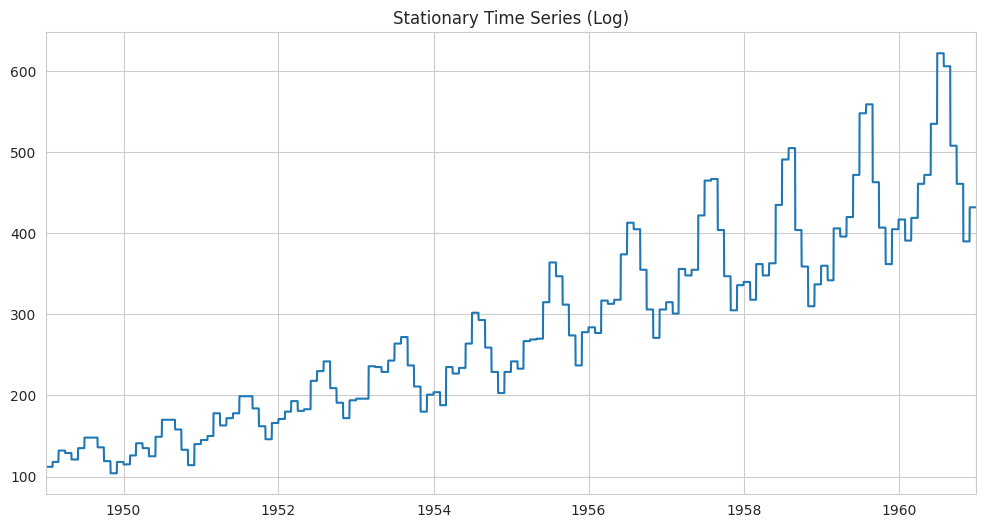

Results of Dickey-Fuller Test:
Test Statistic                   -2.337798
p-value                           0.160067
#Lags Used                       31.000000
Number of Observations Used    4351.000000
Critical Value (1%)              -3.431854
Critical Value (5%)              -2.862205
Critical Value (10%)             -2.567124
dtype: float64


In [55]:
# Apply log transformation to stabilize the variance
# df_log = np.log(df['Passengers'])
df_log=df['Passengers']
# k_log = np.log(k['Passengers'])
k_log=k['Passengers']
# Plot the stationary series
df_log.plot()
plt.title('Stationary Time Series (Log)')
plt.show()

# Retest for stationarity
test_stationarity(df_log)


### WIth only log function the p-value is 0.28>0.05

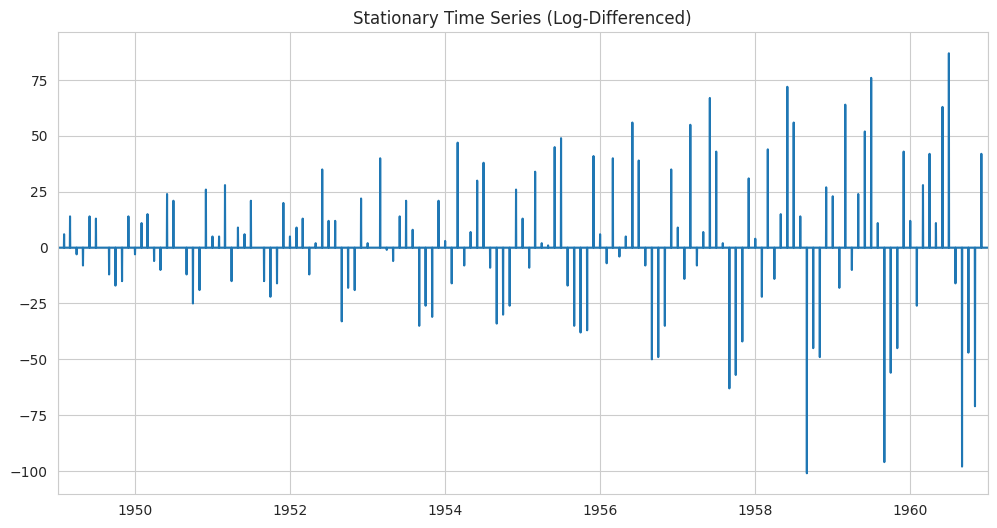

Results of Dickey-Fuller Test:
Test Statistic                -8.650410e+00
p-value                        5.133646e-14
#Lags Used                     3.000000e+01
Number of Observations Used    4.351000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [56]:
# Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()
test_stationarity(df_diff)

### The p-value is 0.01e-14 <0.05
- Original data p-value: 0.991880
- Log-transformed p-value: 0.422367
- Log-differencing p-value: 0.01e-14

### Building the ARIMA Model without differencing

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

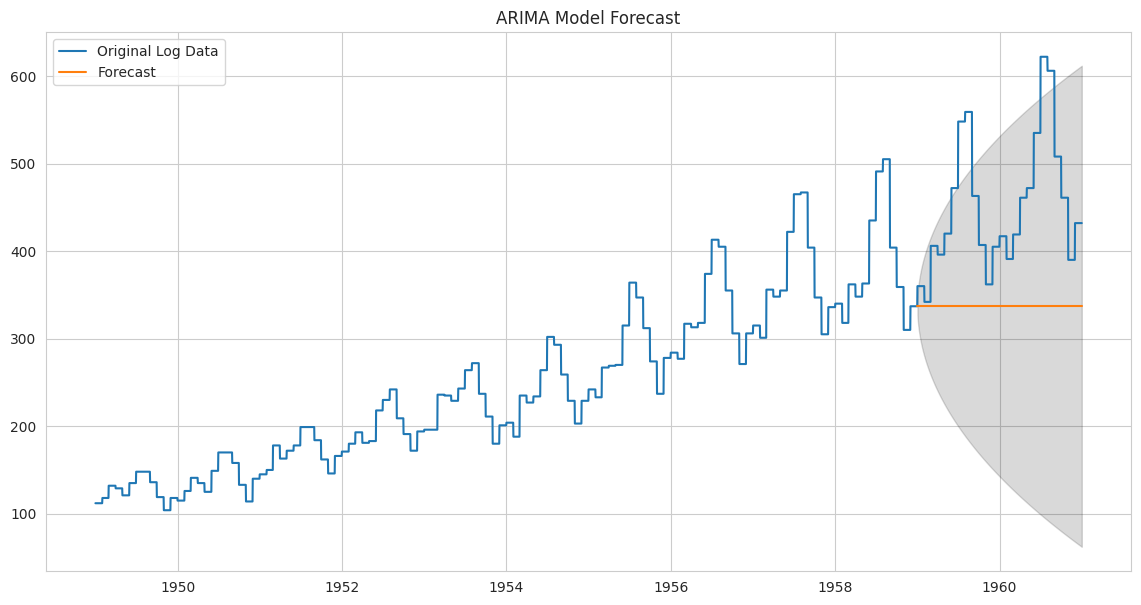

In [57]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]
train1_data = k_log[:'1958']
test1_data = k_log['1959':]
# Build ARIMA model
model = ARIMA(train_data, order=(1,1,1))
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

**ARIMA Result:** The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

###  Building a SARIMA Model for Seasonality

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


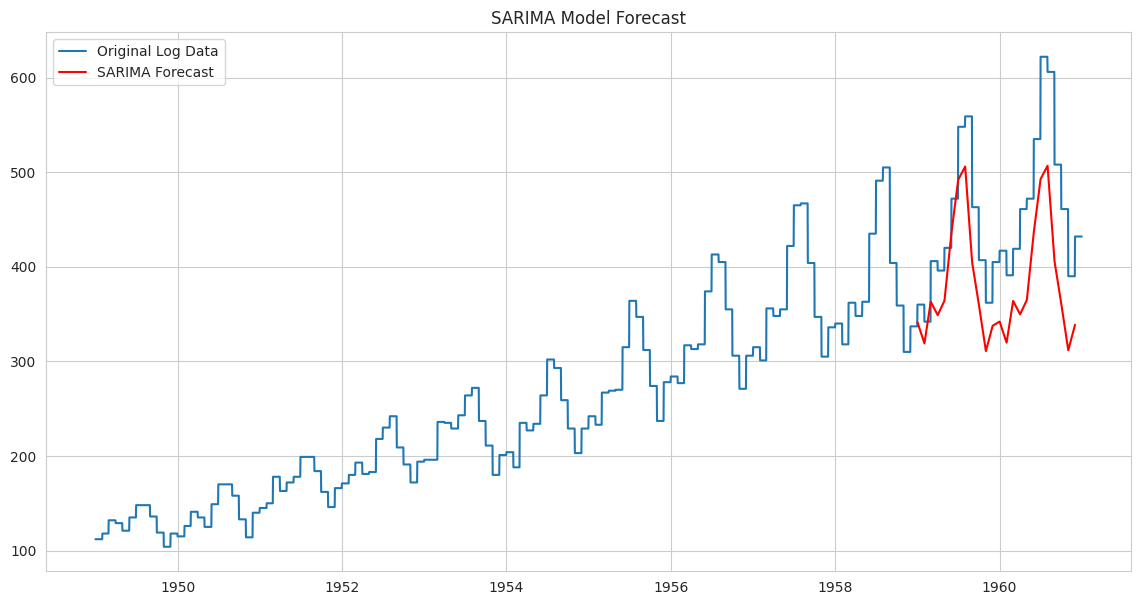

In [58]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train1_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False
                                          ) # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test1_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
#plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.